In [2]:
# 包引用


import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib
import multiprocessing


matplotlib.rc("font",family='KaiTi')  # 中文字体设置


# 示例：N体问题

N体问题:计算物理学的一个重要问题，除了N = 2或在特殊情况下N = 3时，其他情况都没有解析解。
最好的解决方案：使数值近似。
这个问题的**主要部分**适合并行性，而其他部分则不适合。

## 二体问题的一般化

牛顿第二定律和两物体相互作用结合：
$$\frac{dp}{dt}=F=m_i\hat{F}_{ij}m_j$$
大多数情况下可以假定物体质量不变。因此，来自N-1个其他物体的第i个物体上的力如下：
$$F=m_i\frac{d^2 x_i}{dt^2}=\sum\limits^{N}_{j=1,i\gep j}m_i\hat{F}_{ij}m_j$$
根据各个物体的质量和位置，可以计算加速度：
$$a_i=\sum\limits^{N}_{j=1,i\gep j}\hat{F}_{ij}m_j$$
将这个加速度带入标准的时间离散运动方程：
$$v_{i,s}=a_{i,s-1}\Delta t+v_{i,s-1}$$
$$x_{i,s}=a_{i,s-1}\Delta t^2+v_{i,s-1}\Delta t+x_{i,s-1}$$
这些方程将数值求解物体未来的位置、速度、加速度。


In [ ]:
## 非并行问题的求解
# 删除数组中的第i个元素。
def remove_i(x, i):
    shape = (x.shape[0]-1,) + x.shape[1:]
    y = np.empty(shape, dtype=float)
    y[:i] = x[:i]
    y[i:] = x[i+1:]
    return y

# 第i个质量的加速度。
def a(i, x, g, m):
    x_i = x[i]
    x_j = remove_i(x, i)  # 计算物体加速度时要剔除该物体本身。
    m_j = remove_i(m, i)
    diff = x_j - x_i
    mag3 = np.sum(diff**2, axis=1)**1.5
    result = g * np.sum(diff * (m_j / mag3)[:, np.newaxis], axis=0)
    # 计算第i个物体上的加速度。
    return result

# 给定初始条件和时间步长，计算所有质量的下一个位置和速度。
def timestep(x0, v0, g, m, dt):
    n = len(x0)
    x1 = np.empty(x0.shape, dtype=float)
    v1 = np.empty(v0.shape, dtype=float)
    for i in range(n):  # 更新每个时间间隔后的所有物体的位置。
      a_i0 = a(i, x0, g, m)
      v1[i] = a_i0 * dt + v0[i]
      x1[i] = a_i0 * dt**2 + v0[i] * dt + x0[i]
    return x1, v1

# 在D维空间随机位置生成N个静止的统一质量的初始条件。
def initial_cond(n, d):
    x0 = np.random.rand(n, d)  # 该示例模拟器中已经设置好了随机初始条件。
    # 在真实的模拟器中可以手动指定初始物体的位置和速度。
    v0 = np.zeros((n, d), dtype=float)
    m = np.ones(n, dtype=float)
    return x0, v0, m

# 接收位置和速度，并对每个时间间隔进行更新
def simulate(n, d, s, g, dt):
    x0, v0, m = initial_cond(n, d)
    for si in range(s):
        x1, v1 = timestep(x0, v0, g, m, dt)
        x0, v0 = x1, v1


# 数据初始化
x0, v0, m = initial_cond(10, 2)
x1, v1 = timestep(x0, v0, 1.0, m, 1.0e-3)

# 的N值调用simulate()函数，分别计算耗时
Ns = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
runtimes = []
for N in Ns:
    start = time.time()
    simulate(N, 3, 300, 1.0, 1e-3)
    stop = time.time()
    runtimes.append(stop - start)
    print('once finished: ', N)

# 输出结果
## 第一幅
plt.figure(1)
rt1 = [runtimes[i] / runtimes[0] for i in range(len(runtimes))]
plt.plot(Ns, rt1, '-o')
plt.xlabel('物体个数N')
plt.ylabel('相对运行时间，$t_N/t_s$')
plt.title('非并行N体模拟中相对运行时间')

## 第二幅
plt.figure(2)
rt2 = [runtimes[j] / runtimes[int(j/2)] for j in range(len(runtimes))]
plt.plot(Ns, rt2, '-o')
plt.xlabel('物体个数N')
plt.ylabel('翻倍运行时间，$t_N/t_{N/2}$')
plt.title('非并行N体模拟的相对翻倍')

## 多处理的N体问题
多处理下的N体问题，不再需要12.5节中使用的Worker和Pool类。
而只需要一个计算第i个物体随时间间隔变化的timestep_i()函数。
为了使其适应multiprocessing，timestep_i()只能有一个参数。

In [ ]:
## multiprocessing解决
# 删除数组中的第i个元素。
def remove_i(x, i):
    shape = (x.shape[0]-1,) + x.shape[1:]
    y = np.empty(shape, dtype=float)
    y[:i] = x[:i]
    y[i:] = x[i+1:]
    return y

# 第i个质量的加速度。
def a(i, x, g, m):
    x_i = x[i]
    x_j = remove_i(x, i)  # 计算物体加速度时要剔除该物体本身。
    m_j = remove_i(m, i)
    diff = x_j - x_i
    mag3 = np.sum(diff**2, axis=1)**1.5
    result = g * np.sum(diff * (m_j / mag3)[:, np.newaxis], axis=0)
    # 计算第i个物体上的加速度。
    return result

# 计算第i个质量块的下一个位置和速度的并行函数
def timestep_i(args):
    i, x0, v0, g, m, dt = args
    a_i0 = a(i, x0, g, m)
    v_i1 = a_i0 * dt + v0[i]
    x_i1 = a_i0 * dt**2 + v0[i] * dt + x0[i]
    return i, x_i1, v_i1

# 给定初始条件和时间步长，计算所有质量的下一个位置和速度。
def timestep(x0, v0, g, m, dt, pool):
    n = len(x0)
    tasks = [(i, x0, v0, g, m, dt) for i in range(n)]
    results = pool.map(timestep_i, tasks)
    x1 = np.empty(x0.shape, dtype=float)
    v1 = np.empty(v0.shape, dtype=float)
    for i, x_i1, v_i1 in results:
        x1[i] = x_i1
        v1[i] = v_i1
    return x1, v1

# 在D维空间随机位置生成N个静止的统一质量的初始条件。
def initial_cond(n, d):
    x0 = np.random.rand(n, d)  # 该示例模拟器中已经设置好了随机初始条件。
    # 在真实的模拟器中可以手动指定初始物体的位置和速度。
    v0 = np.zeros((n, d), dtype=float)
    m = np.ones(n, dtype=float)
    return x0, v0, m

# 接收位置和速度，并对每个时间间隔进行更新
def simulate(n, d, s, g, dt):
    x0, v0, m = initial_cond(n, d)
    for si in range(s):
        x1, v1 = timestep(x0, v0, g, m, dt)
        x0, v0 = x1, v1

# multiprocessing设置
num_processes = multiprocessing.cpu_count()  # 获取CPU核心数
pool = multiprocessing.Pool(processes=num_processes)

# 数据初始化
x0, v0, m = initial_cond(10, 2)
x1, v1 = timestep(x0, v0, 1.0, m, 1.0e-3, pool)

# N值调用simulate()函数，分别计算耗时
Ps = [1, 2, 4, 8]
runtimes = []
for P in Ps:
    start = time.time()
    simulate(P, 256, 3, 300, 1.0)
    stop = time.time()
    runtimes.append(stop - start)
    print('once finished: ', P)

pool.close()
pool.join()

# 输出结果
## 第一幅
plt.figure(1)
rt1 = [runtimes[i] / runtimes[0] for i in range(len(runtimes))]
plt.plot(Ns, rt1, '-o')
plt.xlabel('物体个数N')
plt.ylabel('相对运行时间，$t_N/t_s$')
plt.title('非并行N体模拟中相对运行时间')

## 第二幅
plt.figure(2)
rt2 = [runtimes[j] / runtimes[int(j/2)] for j in range(len(runtimes))]
plt.plot(Ns, rt2, '-o')
plt.xlabel('物体个数N')
plt.ylabel('翻倍运行时间，$t_N/t_{N/2}$')
plt.title('非并行N体模拟的相对翻倍')

once finished:  2
once finished:  4
once finished:  8
once finished:  16
once finished:  32
once finished:  64
once finished:  128
once finished:  256
once finished:  512
once finished:  1024
once finished:  2048
once finished:  4096
once finished:  8192
Total time comsume is  2.1311533451080322  seconds.


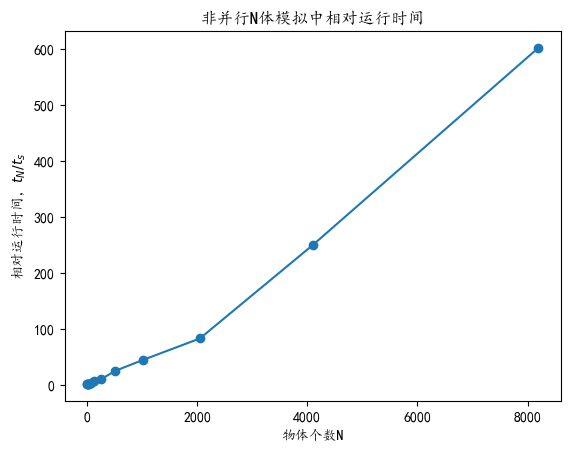

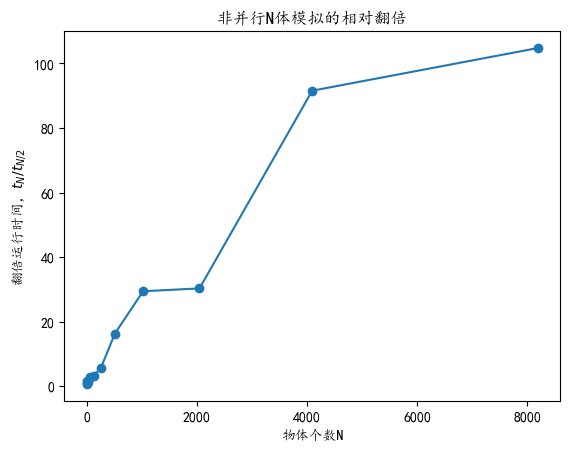

In [13]:
# MPI实现：修改simulate()

# 导入MPI和辅助函数
from mpi4py import MPI  # MPI主模块
from mpi4py.MPI import COMM_WORLD  # COMM_WORLD通信器
from types import FunctionType  # 用于实现MPI进程池


class Pool(object):  # MPI进程池
    def __init__(self):
        self.f = None  # 对执行函数的引用，进程池开始时没有函数
        self.P = COMM_WORLD.Get_size()  # 处理器的总数
        self.rank = COMM_WORLD.Get_rank()  # 所位于的处理器


    def wait(self):  # 当进程池没有任务时接收数据的方法
        if self.rank == 0:  # 主进程不能等待
            raise RuntimeError("Proc 0 cannot wait!")
        status = MPI.Status()
        while True:
            task = COMM_WORLD.recv(source=0, tag=MPI.ANY_TAG, status=status)  # 从主进程接收新任务
            if not task:
                break  # 无新任务，不再接收
            if isinstance(task, FunctionType):  # 如果任务是一个函数，将其放在对象上，然后继续等待
                self.f = task
                continue
            result = self.f(task)  # 调用此任务上的函数并发送回结果
            COMM_WORLD.isend(result, dest=0, tag=status.tag)


    def map(self, f, tasks):  # map()方法
        N = len(tasks)  # 任务数
        P = self.P  # 处理器数
        Pless1 = P - 1  # 留一个处理器用于调度
        if self.rank != 0:  # 让worker等待主进程发出任务
            self.wait()
            return

        if f is not self.f:
            self.f = f
            requests = []
            for p in range(1, self.P):  # 发送所有worker的函数
                r = COMM_WORLD.isend(f, dest=p)
                requests.append(r)
            MPI.Request.waitall(requests)

        requests = []
        for i, task in enumerate(tasks):  # 将任务平均分配给所有worker
            if Pless1 != 0:
                r = COMM_WORLD.isend(task, dest=(i % Pless1)+1, tag=i)
                requests.append(r)
        MPI.Request.waitall(requests)

        results = []
        for i in range(N):  # 等待worker返回结果
            if Pless1 != 0:
                result = COMM_WORLD.recv(source=(i % Pless1)+1, tag=i)
                results.append(result)
        return results


    def __del__(self):
        if self.rank == 0:
            for p in range(1, self.P):  # 当进程池关闭时，关闭所有worker
                COMM_WORLD.isend(False, dest=p)


# 模拟方法

# 删除数组中的第i个元素。
def remove_i(x, i):
    shape = (x.shape[0]-1,) + x.shape[1:]
    y = np.empty(shape, dtype=float)
    y[:i] = x[:i]
    y[i:] = x[i+1:]
    return y

# 第i个质量的加速度。
def a(i, x, g, m):
    x_i = x[i]
    x_j = remove_i(x, i)  # 计算物体加速度时要剔除该物体本身。
    m_j = remove_i(m, i)
    diff = x_j - x_i
    mag3 = np.sum(diff**2, axis=1)**1.5
    result = g * np.sum(diff * (m_j / mag3)[:, np.newaxis], axis=0)
    # 计算第i个物体上的加速度。
    return result

# 计算第i个质量块的下一个位置和速度的并行函数
def timestep_i(args):
    i, x0, v0, g, m, dt = args
    a_i0 = a(i, x0, g, m)
    v_i1 = a_i0 * dt + v0[i]
    x_i1 = a_i0 * dt**2 + v0[i] * dt + x0[i]
    return i, x_i1, v_i1

# 给定初始条件和时间步长，计算所有质量的下一个位置和速度。
def timestep(x0, v0, g, m, dt, pool):
    n = len(x0)
    tasks = [(i, x0, v0, g, m, dt) for i in range(n)]
    results = pool.map(timestep_i, tasks)
    x1 = np.empty(x0.shape, dtype=float)
    v1 = np.empty(v0.shape, dtype=float)
    for i, x_i1, v_i1 in results:
        x1[i] = x_i1
        v1[i] = v_i1
    return x1, v1

# 在D维空间随机位置生成N个静止的统一质量的初始条件。
def initial_cond(n, d):
    x0 = np.random.rand(n, d)  # 该示例模拟器中已经设置好了随机初始条件。
    # 在真实的模拟器中可以手动指定初始物体的位置和速度。
    v0 = np.zeros((n, d), dtype=float)
    m = np.ones(n, dtype=float)
    return x0, v0, m

# 接收位置和速度，并对每个时间间隔进行更新
def simulate(N, D, S, G, dt):
    x0, v0, m = initial_cond(N, D)
    pool = Pool()
    if COMM_WORLD.Get_rank() == 0:
        for s in range(S):
            x1, v1 = timestep(x0, v0, G, m, dt, pool)
            x0, v0 = x1, v1
    else:
        pool.wait()

if __name__ == '__main__':
    start_t = time.time()
    # 数据初始化
    x0, v0, m = initial_cond(10, 2)
    # x1, v1 = timestep(x0, v0, 1.0, m, 1.0e-3, pool)
    # simulate(128, 3, 300, 1.0, 1e-3)

    # 的N值调用simulate()函数，分别计算耗时
    Ns = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
    runtimes = []
    for N in Ns:
        start = time.time()
        simulate(N, 3, 300, 1.0, 1e-3)
        stop = time.time()
        runtimes.append(stop - start)
        print('once finished: ', N)

    # 输出结果
    ## 第一幅
    plt.figure(1)
    rt1 = [runtimes[i] / runtimes[0] for i in range(len(runtimes))]
    plt.plot(Ns, rt1, '-o')
    plt.xlabel('物体个数N')
    plt.ylabel('相对运行时间，$t_N/t_s$')
    plt.title('非并行N体模拟中相对运行时间')

    ## 第二幅
    plt.figure(2)
    rt2 = [runtimes[j] / runtimes[int(j/2)] for j in range(len(runtimes))]
    plt.plot(Ns, rt2, '-o')
    plt.xlabel('物体个数N')
    plt.ylabel('翻倍运行时间，$t_N/t_{N/2}$')
    plt.title('非并行N体模拟的相对翻倍')
    end_t = time.time()
    print("Total time comsume is ", end_t - start_t, " seconds.")